Nama: Phoebe Patricia Wibowo <br>
NIM: 2602080825

Link Presentasi: https://drive.google.com/drive/folders/1Ntl_IXiUtefHnS7voy5G5kIXGK1t7Wh6?usp=sharing

In [2]:
#import libraries
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Flatten, Dense, Reshape, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.optimizers import Adam

No2A.  Lakukan loading dan scaling data serta tampilkan contoh data yang 
digunakan. Kemudian pisahkan dataset menjadi 80% training set, 10% validation set dan 10% 
test se

In [3]:
# Muat dataset Fashion MNIST
(x_data, y_data), (_, _) = fashion_mnist.load_data()

# Filter hanya "baju" (kelas 6) dan "sepatu" (kelas 7)
filter_data = np.where((y_data == 6) | (y_data == 7))
x_data, y_data = x_data[filter_data], y_data[filter_data]

# Normalisasi dan reshape data
x_data = x_data.astype('float32') / 255.0
x_data = np.expand_dims(x_data, axis=-1)  # Tambahkan dimension kernel (28, 28, 1)

# Split menjadi pelatihan (80%) dan sementara (20%) untuk pembagian lebih lanjut
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Split sementara menjadi validasi (10% dari data asli) dan uji (10% dari data asli)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# konversi test,train dan validation data menjadi tensor 
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Buat TensorDatasets
train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
val_dataset = TensorDataset(x_val_tensor, x_val_tensor)
test_dataset = TensorDataset(x_test_tensor, x_test_tensor)

# Buat DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

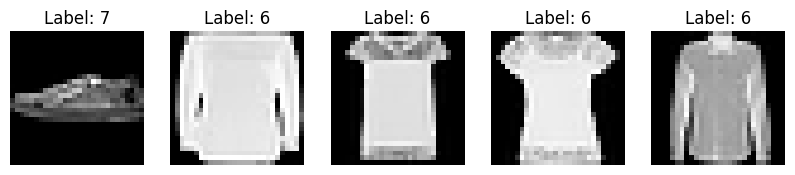

In [6]:
import matplotlib.pyplot as plt

# Menampilkan gambar dan label
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

show_images(x_train, y_train, num_images=5)


No2B. [LO 3, LO 4, 8 poin] Buatlah arsitektur baseline untuk Dimension Reduction dari dimensi 784  (28x28) menjadi dimensi 128, sesuai dengan gambar arsitektur Autoencoder berikut ini. Lakukan evaluasi kualitas citra hasil decoder menggunakan Structural Similarity Index (SSIM) pada data test.

In [4]:
# Encoder
encoder_input = Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
latent = Dense(128, activation='relu', name='latent')(x)

encoder = Model(encoder_input, latent, name='encoder')
encoder.summary()

# Decoder
decoder_input = Input(shape=(128,), name='decoder_input')
x = Dense(6272, activation='relu')(decoder_input)
x = Reshape((14, 14, 32))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

# Autoencoder
autoencoder_input = encoder_input
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)

autoencoder = Model(autoencoder_input, decoded, name='autoencoder')
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_val, x_val))

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 819,776 (3.13 MB)

 Trainable params: 819,776 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 818,625 (3.12 MB)

 Trainable params: 818,625 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 128)            │       819,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       818,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,638,401 (6.25 MB)

 Trainable params: 1,638,401 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.5142 - val_loss: 0.3535
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.3317 - val_loss: 0.3060
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.3015 - val_loss: 0.2957
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2932 - val_loss: 0.2899
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2849 - val_loss: 0.2864
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2823 - val_loss: 0.2826
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2797 - val_loss: 0.2799
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2755 - val_loss: 0.2785
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2747 - val_loss: 0.2765
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2738 - val_loss: 0.2757
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2723 - val_loss: 0.2741
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2

In [5]:
# Menghitung SSIM menggunakan fungsi 
def evaluate_ssim(autoencoder_model, x_test_data):
    ssim_scores = []
    for i in range(len(x_test_data)):
        original_image = x_test_data[i]
        reconstructed_image = autoencoder_model.predict(np.array([original_image]))[0]
        
        original_image_reshaped = original_image.reshape((28, 28))
        reconstructed_image_reshaped = reconstructed_image.reshape((28, 28))
        ssim_score = ssim(original_image_reshaped, reconstructed_image_reshaped, data_range=reconstructed_image_reshaped.max() - reconstructed_image_reshaped.min())
        ssim_scores.append(ssim_score)
    return ssim_scores

In [6]:
# evaluasi SSIM encoder 
ssim_scores_base = evaluate_ssim(autoencoder, x_test)
# ssim_scores_base.append(ssim_score_base)
print(f"Average SSIM for base autoencoder: {np.mean(ssim_scores_base)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

Rata-rata SSIM untuk autoencoder dasar adalah 0.8106688656819112 menunjukkan bahwa kedua gambar tersebut cukup mirip. Skornya tidak terlalu tinggi, menunjukkan bahwa ada beberapa perbedaan di antara gambar-gambar tersebut. Namun, angkanya juga tidak terlalu rendah, yang menunjukkan bahwa gambar-gambar tersebut memiliki beberapa kesamaan. Skor ini dapat digunakan untuk mengevaluasi kualitas algoritma pemrosesan gambar, seperti kompresi, denoising, atau peningkatan, dengan membandingkan gambar keluaran dengan gambar aslinya.

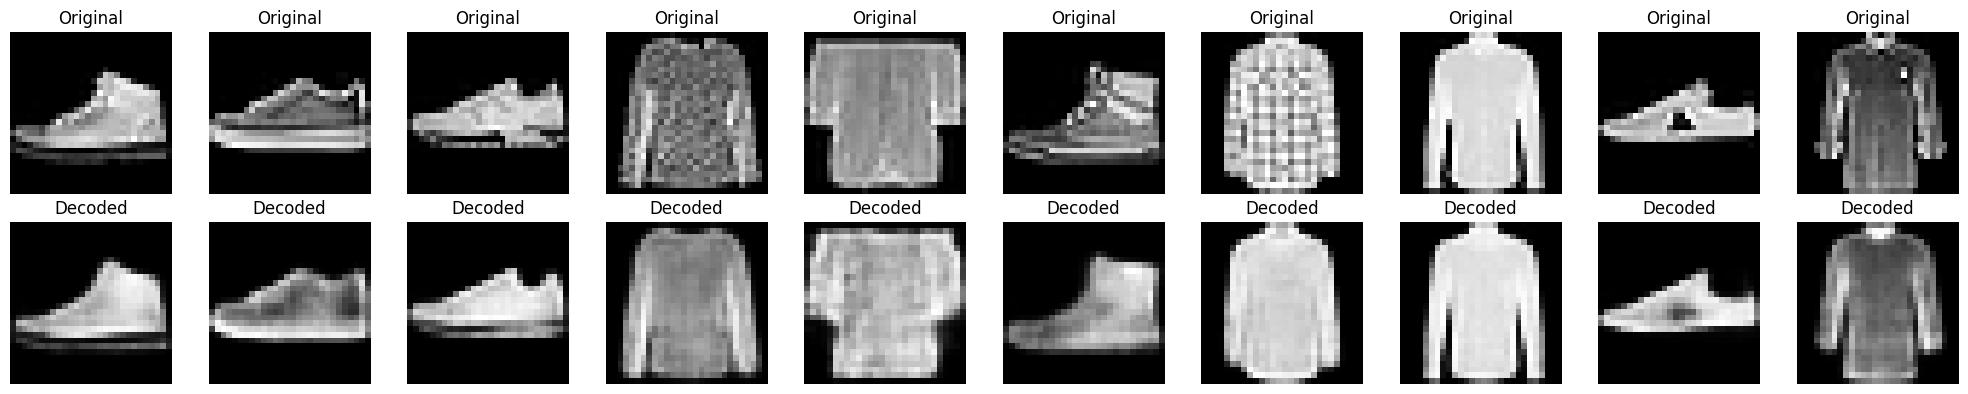

In [7]:
#plotting images orignal dan decoded
def plot_images(orig, decoded, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(orig[i].numpy().reshape(28, 28), cmap='gray')  # Convert from tensor to numpy array
        plt.title("Original")
        plt.axis('off')

        # Display decoded images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded[i].numpy().reshape(28, 28), cmap='gray')  # Convert from tensor to numpy array
        plt.title("Decoded")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(x_test_tensor[:10], autoencoder(x_test_tensor[:10]))

Setelah mengetahui hasil dari nomor (2b), modifikasi arsitektur 
Autoencoder di atas agar mendapatkan representasi Dimension Reduction yang optimal
dengan membandingkan hasil Structural Similarity Index (SSIM) nya. Dan selanjutnya lakukan 
proses tuning hyperparameter agar unjuk kerjanya meningkat. Berikan alasan mengapa 
modifikasi arsitektur dan metode tuning hyperparameter kalian lebih baik

Model 2

In [9]:
# Encoder
input_img2 = Input(shape=(28, 28, 1))
model2 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img2)
model2 = BatchNormalization()(model2)
model2 = MaxPooling2D((2, 2), padding='same')(model2)
model2 = Flatten()(model2)
model2 = Dropout(0.4)(model2)
encoded = Dense(128, activation='relu')(model2)

# Decoder
model2 = Dense(6272, activation='relu')(encoded)
model2 = Reshape((14, 14, 32))(model2)
model2 = UpSampling2D((2, 2))(model2)
model2 = Conv2D(32, (3, 3), activation='relu', padding='same')(model2)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(model2)


autoencoder2_input = Input(shape=(28, 28, 1))
encoded = encoder(autoencoder2_input)
decoded = decoder(encoded)
autoencoder2 = Model(autoencoder2_input, decoded)


autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder2.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_val, x_val))

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2884 - val_loss: 0.2657
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2599 - val_loss: 0.2622
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.2574 - val_loss: 0.2617
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2597 - val_loss: 0.2615
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2591 - val_loss: 0.2614
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2568 - val_loss: 0.2615
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2573 - val_loss: 0.2615
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2574 - val_loss: 0.2613
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2572 - val_loss: 0.2614
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2569 - val_loss: 0.2612
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2576 - val_loss: 0.2614
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2

In [10]:
decoded_imgs = autoencoder2.predict(x_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [11]:
#Memberi SSIM Score yang dibuat oleh model yang teroptimized
ssim_score_optimized = evaluate_ssim(autoencoder2, x_test)
print(f"Average SSIM Score for optimized autoencoder: {np.mean(ssim_score_optimized)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

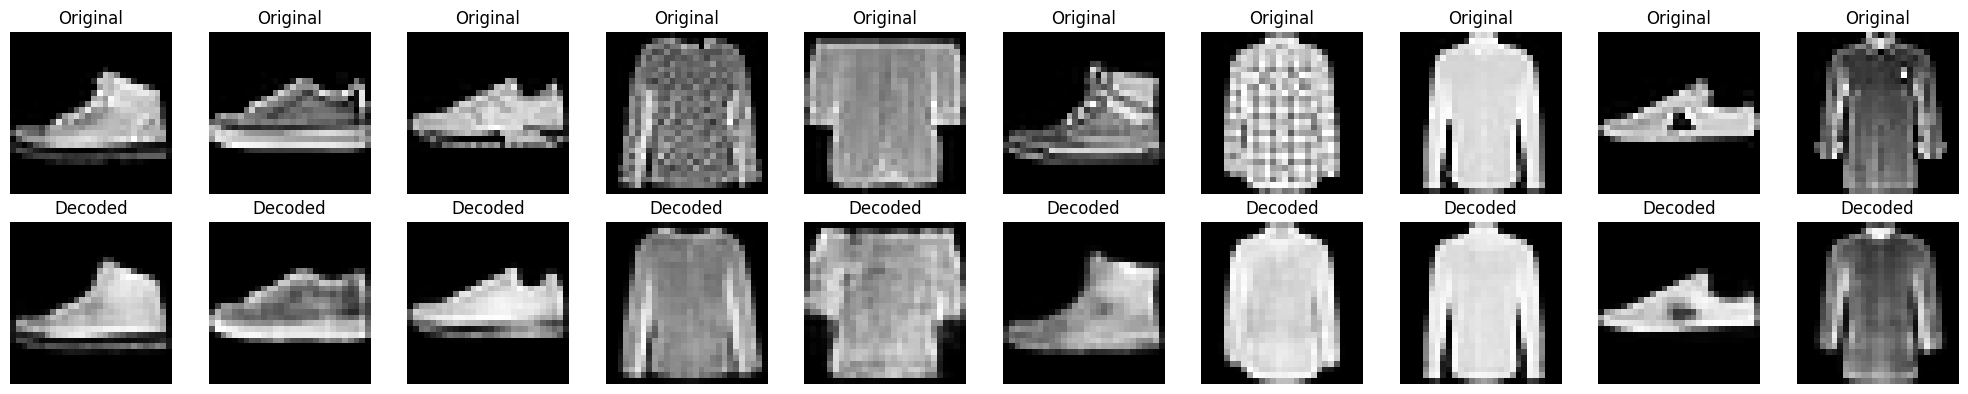

In [12]:
plot_images(x_test_tensor[:10], autoencoder2(x_test_tensor[:10]))

Autoencoder yang diperbaiki memiliki nilai SSIM yang lebih tinggi (0.8323782182450603) di model kedua dibandingkan dengan autoencoder dasar (0.8106688656819112). Hal ini menunjukkan bahwa autoencoder yang diperbaiki lebih baik dalam hal kesamaan struktural, yang adalah ukuran kesamaan antara gambar asli dan gambar yang diperbarui. Oleh karena itu, autoencoder2 yang diperbaiki lebih baik dalam hal ini.